In [46]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error
from kerasbeats import prep_time_series
from kerasbeats import NBeatsModel


In [47]:
# Ensure reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [48]:
df = pd.read_csv("../data/processed/aggregated-dataset.csv")
df["date"] = pd.to_datetime(df["date"])

In [49]:
df

,date,sst
0,2024-01-01,28.943655
1,2024-01-02,28.981403
2,2024-01-03,29.042894
3,2024-01-04,29.046002
4,2024-01-05,29.014890
...,...,...
177,2024-06-26,30.149940
178,2024-06-27,30.117995
179,2024-06-28,30.125019
180,2024-06-29,30.169469


In [ ]:
# Time series generator for sliding window
X, y = prep_time_series(df['sst'], lookback = 7, horizon = 1)

# Split into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle = False, test_size=0.2, random_state=42)

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("train-nbeats")

with mlflow.start_run():

    # Train model
    model = NBeatsModel(
        model_type = 'generic', 
        lookback = 7, 
        horizon = 1)
    
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

    # Evaluate 
    predictions = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, predictions)
    mse = mean_squared_error(y_val, predictions)
    mae = mean_absolute_error(y_val, predictions)

    # Log parameters
    mlflow.log_param("model_type", "generic")
    mlflow.log_param("lookback", 7)
    mlflow.log_param("horizon", 1)
    mlflow.log_param("epochs", 50)

    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)

    # Save model
    mlflow.keras.log_model(model.model, artifact_path="nbeats-trained")


SyntaxError: invalid syntax (3844392156.py, line 38)

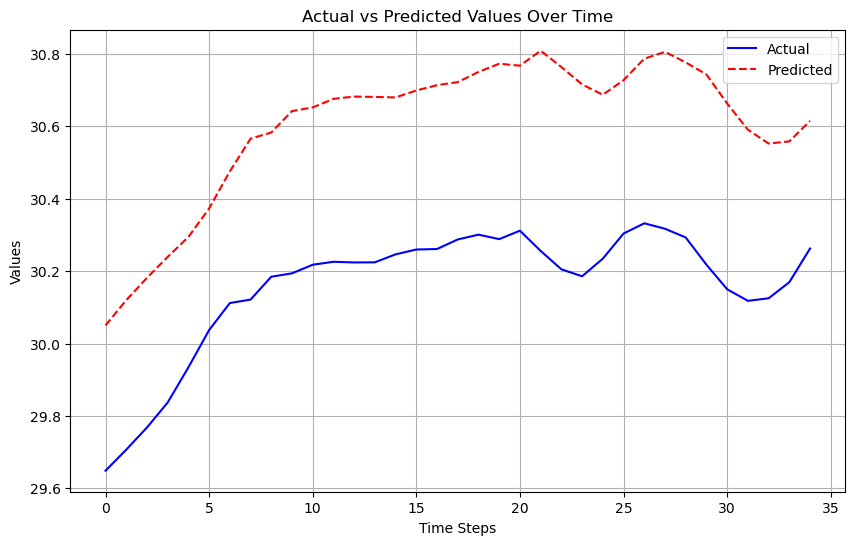

In [ ]:
# Plot the actual vs predicted values over time
plt.figure(figsize=(10, 6))
# Plot actual values (validation set) and predicted values
plt.plot(y_val, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

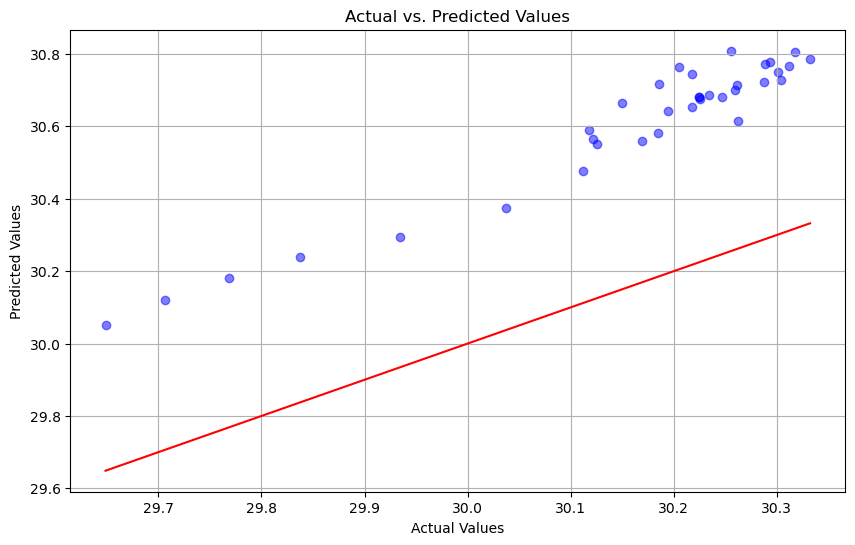

In [ ]:
# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, predictions, color='blue', alpha=0.5) 
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()